In [1]:
import numpy as np
import os
import glob
import pandas as pd
from sklearn.manifold import Isomap,\
                            LocallyLinearEmbedding,\
                            SpectralEmbedding,\
                            TSNE,\
                            locally_linear_embedding
from umap import UMAP
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import ParameterGrid

from joblib import Parallel, delayed
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from utils import transform, calculate_Q_metrics, KNN_MAE
from IPython.display import clear_output
N_CPU = cpu_count()

import warnings
warnings.simplefilter("ignore")
plt.rcParams.update({'font.size': 20})

# Load data

In [2]:
DATA_SPECIFICATION = '' #'_pat0.4'

intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict{DATA_SPECIFICATION}.npy', allow_pickle=True).item()

data_orig = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values

data_pca = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')
        
embeddings_root = f'results/embeddings{DATA_SPECIFICATION}'
embeddings_params_root = f'results/embeddings_params{DATA_SPECIFICATION}/'

os.makedirs(embeddings_root, exist_ok=True)
os.makedirs(embeddings_params_root, exist_ok=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


In [3]:
# # uncomment to use synthetic data

# intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict_synthetic.npy', allow_pickle=True).item()

# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')

    
# embeddings_root = 'results/embeddings_synthetic'
# embeddings_params_root = 'results/embeddings_params_synthetic/'

# os.makedirs(embeddings_root, exist_ok=True)
# os.makedirs(embeddings_params_root, exist_ok=True)

# Hyperparameters Grid Search

In [4]:
# heavily slowes the hyperparameter search,
# but allows to estimate Q-metrics for each combination
include_Q_scores = False

knn_mae_scorer = lambda *args: KNN_MAE(*args, averaging='median', weights='distance', n_neighbors=5)

if include_Q_scores:
    scorer = lambda *args: (calculate_Q_metrics(*args) + [knn_mae_scorer(*args)])
else:
    scorer = knn_mae_scorer

In [5]:
baseline_errors = {}
for label, X in tqdm((data_pca.items())):
    baseline_errors[label] = knn_mae_scorer(X,X)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.01it/s]


In [ ]:
mf_models = {
    
#             'isomap':{'class':Isomap, 'params_grid':{'n_neighbors':[5,10,15,25],
#                                                       'p':[1,2],
#                                                       'metric':['minkowski'],
#                                                       'n_jobs':[1]
#                                                      }
#                       },
    
    
#             'spectral':{'class':SpectralEmbedding, 'params_grid':{'affinity':['nearest_neighbors', 'rbf'],
#                                                                    'n_neighbors':[5,10,15,25],
#                                                                    'gamma':[1e-4, 1e-3, 1e-2, None, 1e-1],
#                                                                    'random_state':[42],
#                                                                    'n_jobs':[1]
#                                                                   }
#                         },
    

#             'lle':{'class':LocallyLinearEmbedding, 'params_grid':{'method':['ltsa', 'standard'],
#                                                        'reg':[0.0001, 0.001, 0.01],
#                                                        'n_neighbors':[10,15,25,50],
#                                                        'random_state':[42],
#                                                        'n_jobs':[1],
#                                                        'eigen_solver':['dense']
#                                                      }
#                   },
    
#             'umap':{'class':UMAP, 'params_grid':{'n_neighbors':[5,10,15,25,50],
#                                                  'min_dist':[0.05, 0.1, 0.25, 0.5],
#                                                  'learning_rate':[0.1, 1],
#                                                  'random_state':[42],
#                                                  'metric':['manhattan'],
#                                                  'n_epochs':[2000], # changerd from 2000
#                                                  'n_jobs':[1]
#                                                 }
#                    },
    
            'tsne':{'class':TSNE, 'params_grid':{'perplexity':[5,10,15,25,50],
                                                 'random_state':[42],
                                                 'early_exaggeration':[5,10,25],
                                                 'init':['pca'],
                                                 'metric':['manhattan'],
                                                 'method':['exact'],
                                                 'n_jobs':[1],
                                                 'n_iter':[2000],
                                                 'n_iter_without_progress':[100]
                                                 }
                   } 
            }

# iterate over the models
for mf_type, model in mf_models.items():    
    # iterate over the datasets
    for i,(label, X) in tqdm(enumerate(data_pca.items())):
        
        results = {}
        results_path = os.path.join(embeddings_params_root,\
                                    f'pca_{mf_type}_{label}')
        
        if os.path.isfile(results_path + '.npy'):
            print(f'{results_path} exists, skipping...')
            continue

        dim = intrinsic_dims[label]
        print('Calculating...', label, 'Method:', mf_type, 'Intrinsic dim:', dim)

        model_class = model['class']
        model_param_grid = model['params_grid']
        
        try:
            scores = Parallel(n_jobs=-1)(delayed(transform)(model_class,
                                                            X, 
                                                            dim,
                                                            model_params,
                                                            scorer) \
                              for model_params in list(ParameterGrid(model_param_grid)))  
            
            results['scores'] = scores
            results['params'] = model_param_grid
            np.save(results_path, results)
            
        except Exception as e:
            print(f'Failed to estimate perameters for {mf_type}, {label}:', e)
            continue
            
clear_output()

0it [00:00, ?it/s]

Calculating... AGP_o Method: tsne Intrinsic dim: 6


In [9]:
ls -la ./results/embeddings_params/

total 128
drwxr-xr-x  2 ibulygin users 4096 апр 12 13:51 ./
drwxr-xr-x 18 ibulygin users 4096 апр 11 19:25 ../
-rw-r--r--  1 ibulygin users  671 апр 11 19:32 pca_isomap_AGP_f.npy
-rw-r--r--  1 ibulygin users  671 апр 11 19:34 pca_isomap_AGP_g.npy
-rw-r--r--  1 ibulygin users  671 апр 11 19:29 pca_isomap_AGP_o.npy
-rw-r--r--  1 ibulygin users  671 апр 11 19:34 pca_isomap_HMP_f.npy
-rw-r--r--  1 ibulygin users  671 апр 11 19:35 pca_isomap_HMP_g.npy
-rw-r--r--  1 ibulygin users  671 апр 11 19:34 pca_isomap_HMP_o.npy
-rw-r--r--  1 ibulygin users 1119 апр 11 20:31 pca_lle_AGP_f.npy
-rw-r--r--  1 ibulygin users 1119 апр 11 20:53 pca_lle_AGP_g.npy
-rw-r--r--  1 ibulygin users 1119 апр 11 20:08 pca_lle_AGP_o.npy
-rw-r--r--  1 ibulygin users 1119 апр 11 20:58 pca_lle_HMP_f.npy
-rw-r--r--  1 ibulygin users 1119 апр 11 21:01 pca_lle_HMP_g.npy
-rw-r--r--  1 ibulygin users 1119 апр 11 20:56 pca_lle_HMP_o.npy
-rw-r--r--  1 ibulygin users 1458 апр 11 19:41 pca_spectral_AGP_f.npy
-rw-r--r--  1 ibulygi

# Visualization

In [10]:
all_metrics = defaultdict(dict)

for metrics_results_name in \
                   filter(lambda x: 'pca' in x, os.listdir(embeddings_params_root)):
    
    mf_type, dataset_name, tax_name = metrics_results_name.split('.')[0].split('_')[-3:]
    label = '_'.join([dataset_name, tax_name])
    all_metrics[mf_type][label] = np.load(os.path.join(embeddings_params_root, 
                                          metrics_results_name), \
                                          allow_pickle=True).item()

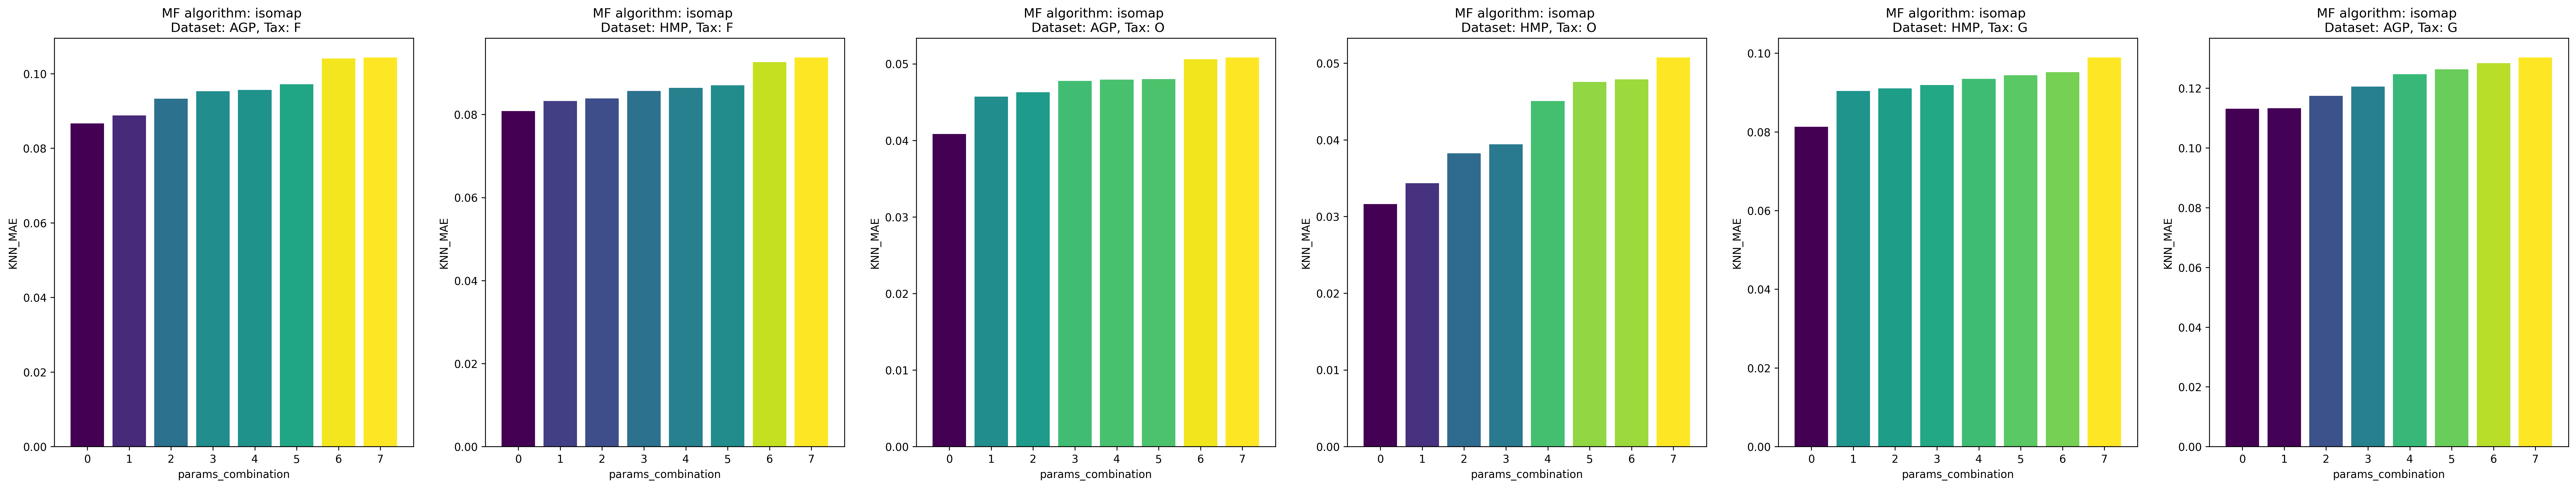

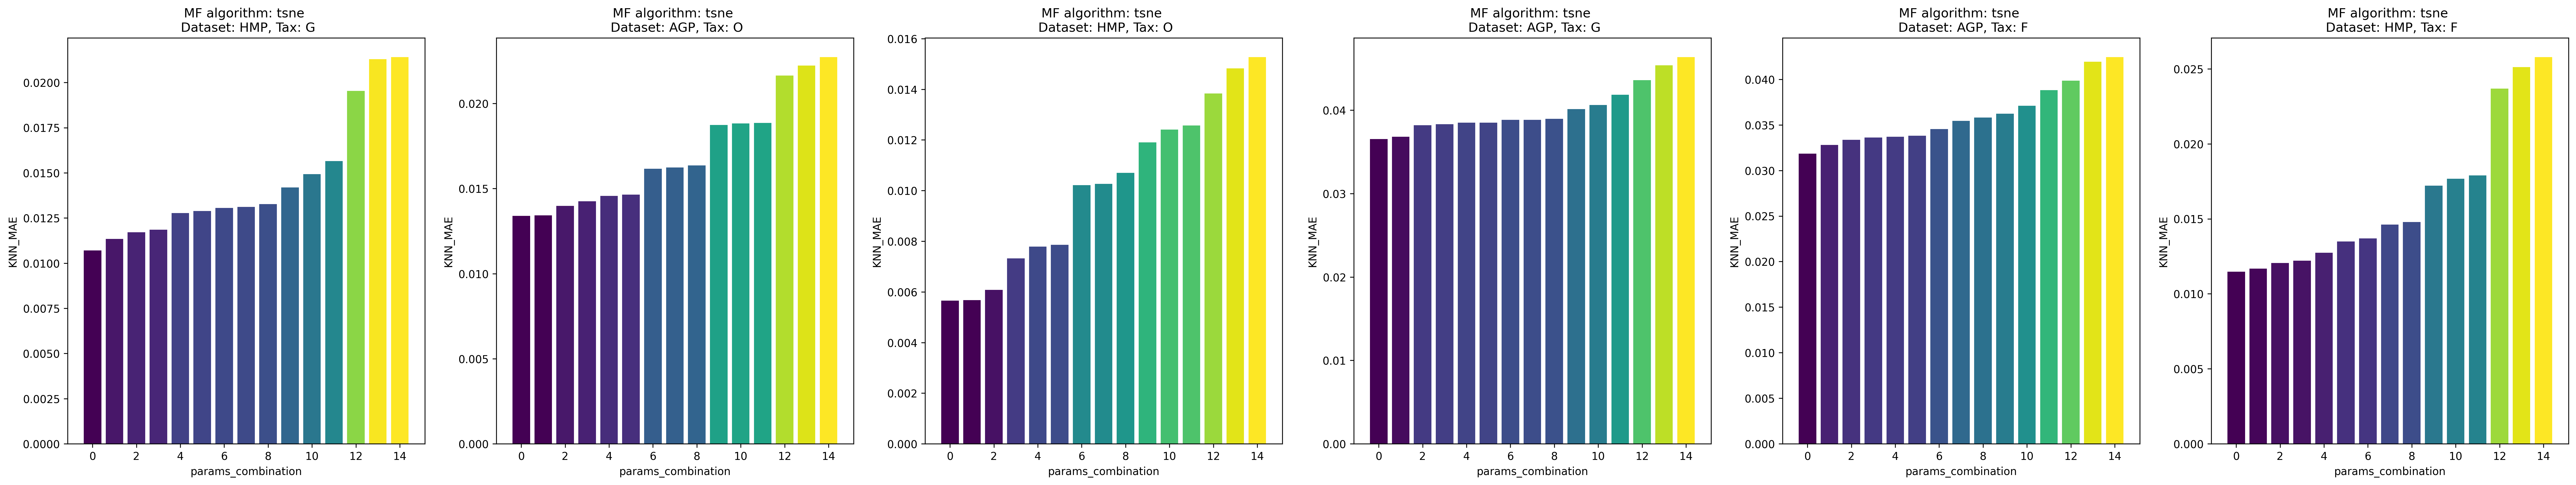

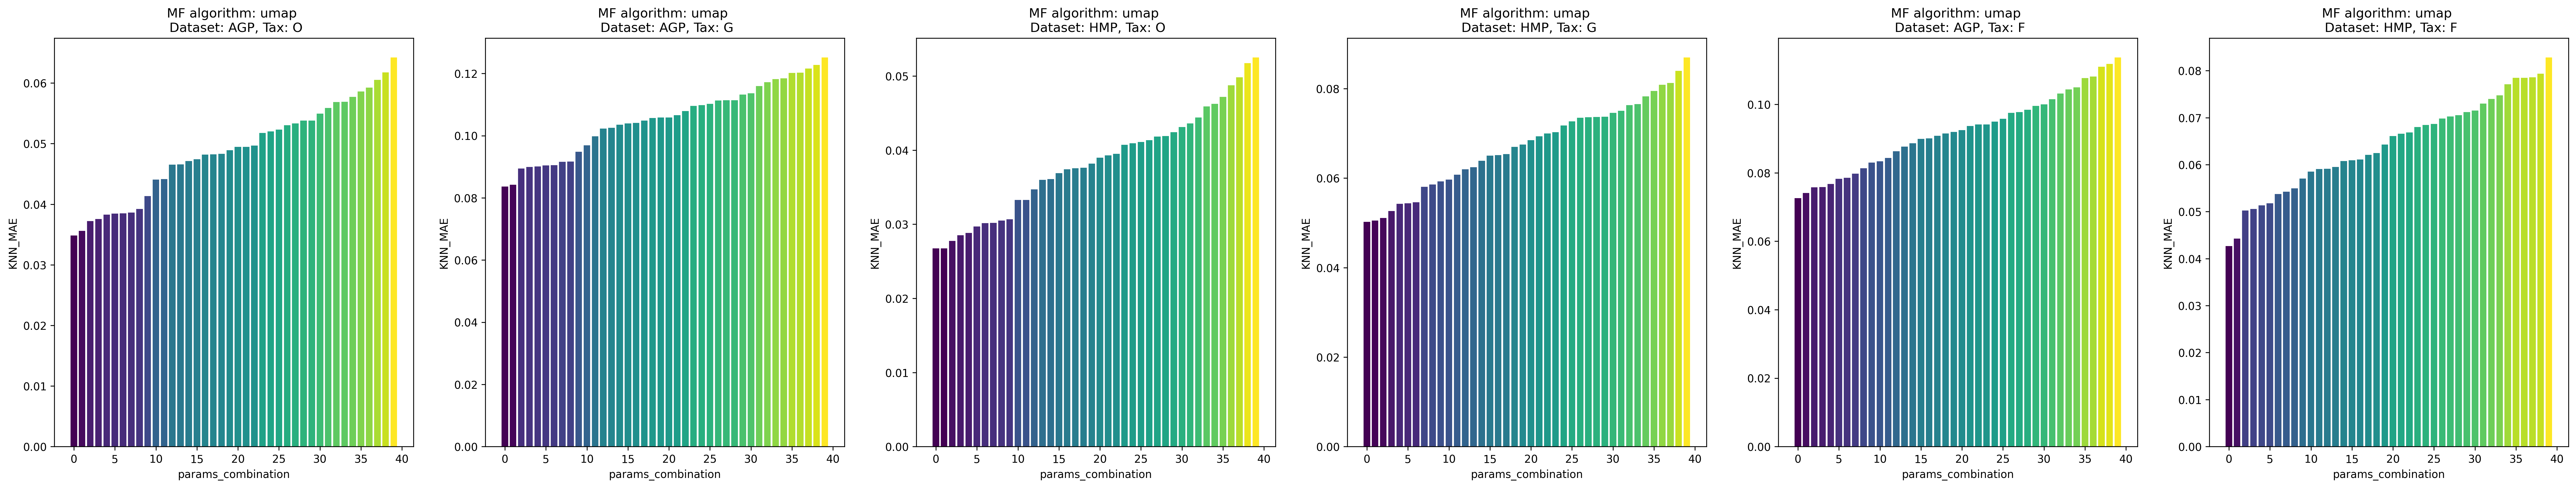

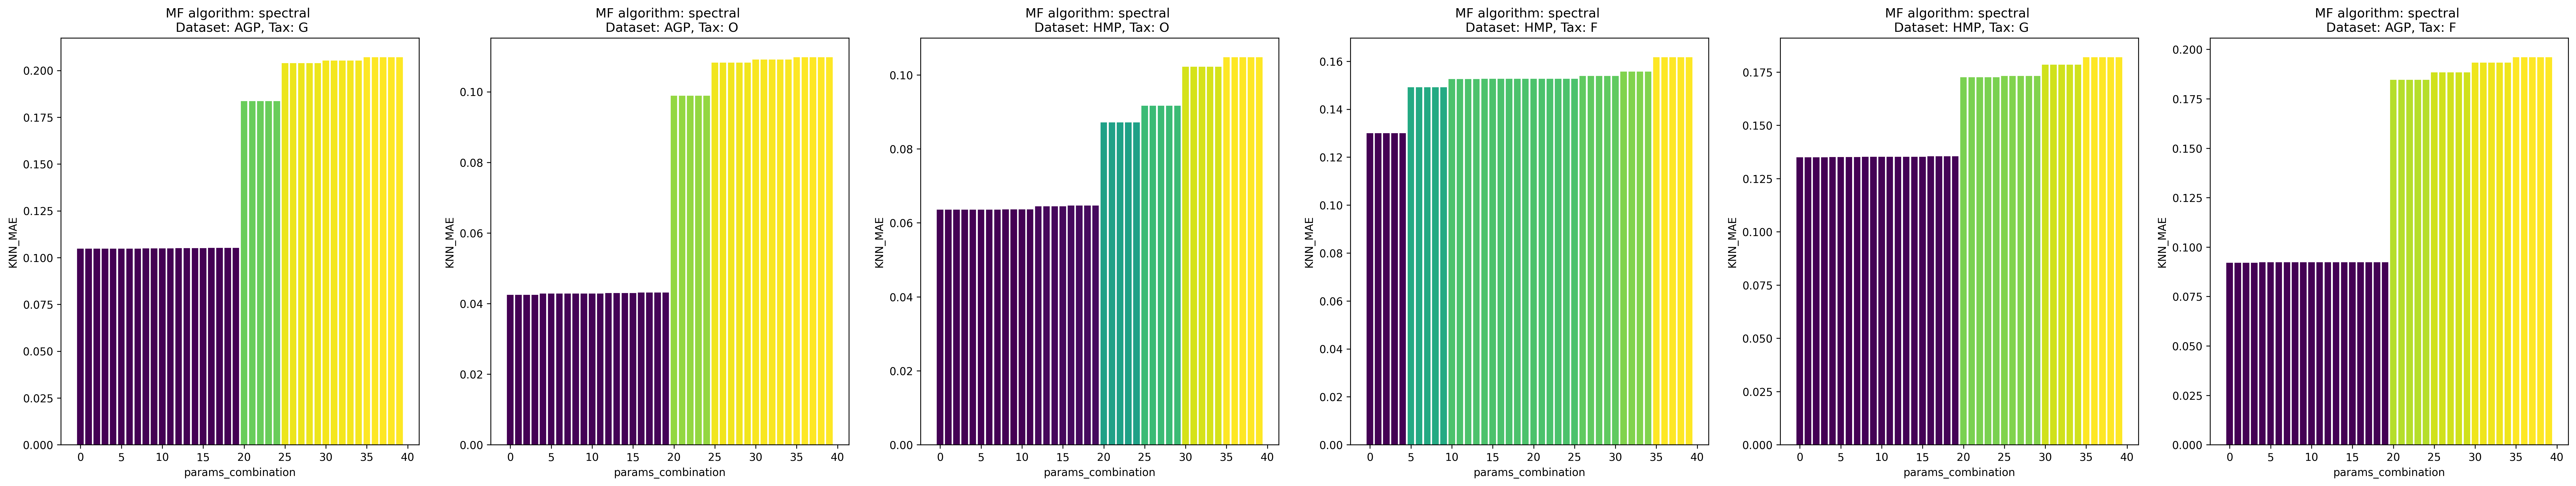

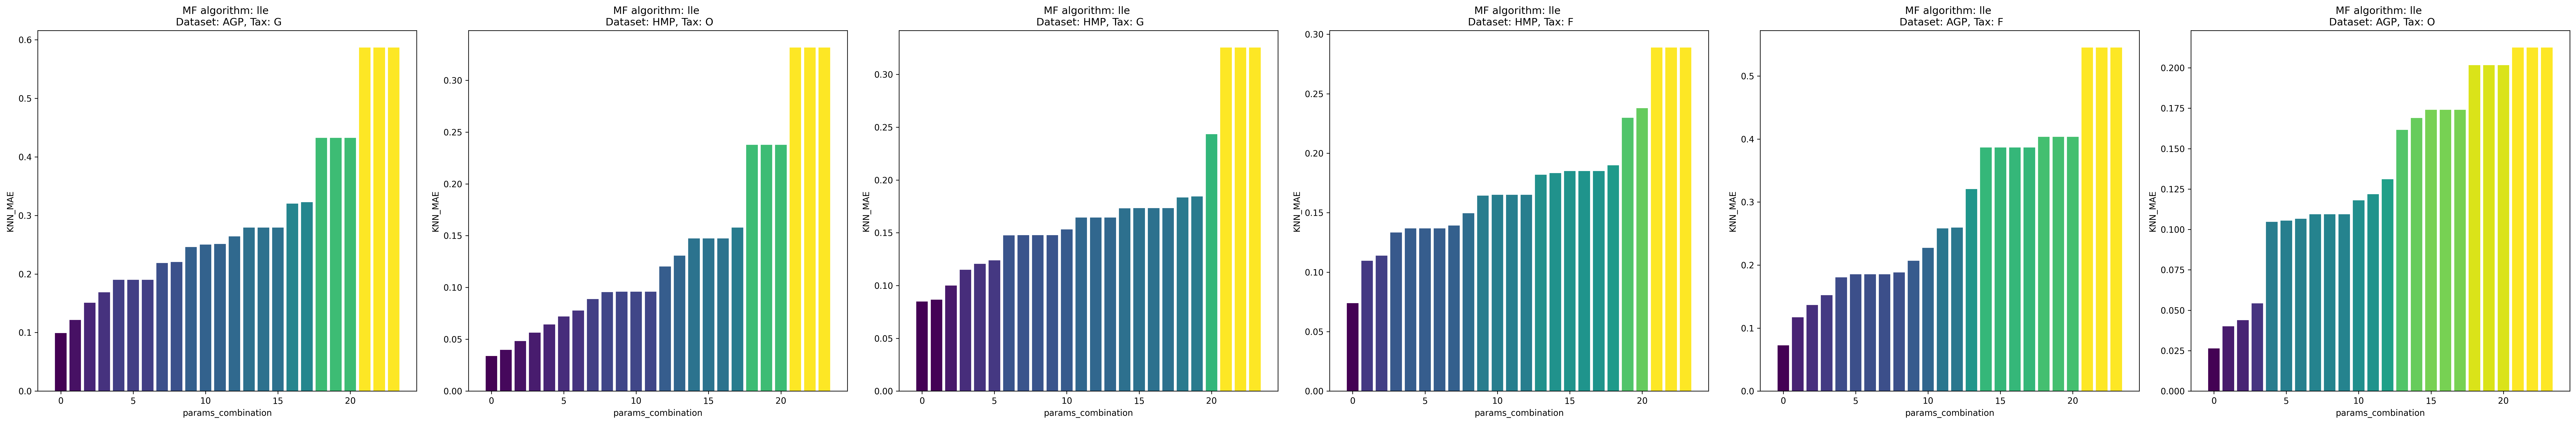

In [11]:
plt.rcParams.update({'font.size': 20})
best_params = defaultdict(dict)

my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

for mf_type, mf_metrics in all_metrics.items():
    mf_metrics_items = mf_metrics.items()
    
    fig, axes = plt.subplots(nrows=1, 
                             ncols = len(mf_metrics_items), 
                             figsize=(len(mf_metrics_items)*7, 7), 
                             dpi=300)
    
    for i,(label, mf_label_metrics) in enumerate(mf_metrics_items):
        
        scores = np.array(mf_label_metrics['scores'])
        params = list(ParameterGrid(mf_label_metrics['params']))
        dataset_name = label.split('_')[0]
        tax_name = label.split('_')[-1]
        
#         maes = scores[:,-1] if scores.ndim > 1 else scores
        
        if include_Q_scores:
            maes = scores[:,-1]
        else:
            maes = scores
            
        mae_argmin = maes.argmin()
        
        best_params[label][mf_type] = params[mae_argmin] 
        
        # scatterplot with Q-metrics
        if include_Q_scores:
            sc = axes[i].scatter(scores[:,0], scores[:,1], c=scores[:,2])
            axes[i].set_xlabel('Q_loc')
            axes[i].set_ylabel('Q_glob')
        
        else:
            scores_rel = scores - baseline_errors[label]
            scores_rel = sorted(scores_rel)
            axes[i].bar(np.arange(len(scores_rel)), scores_rel, color=my_cmap(rescale(scores_rel)))
            axes[i].set_xlabel('params_combination')
            axes[i].set_ylabel('KNN_MAE')
            
        axes[i].set_title(f'MF algorithm: {mf_type} \n Dataset: {dataset_name}, Tax: {tax_name.capitalize()}')
        
            
    if include_Q_scores:
        fig.colorbar(sc, orientation='vertical')
        
plt.tight_layout()        
plt.show()

# Train final embeddings

In [21]:
methods_dict = {
                'tsne':TSNE,
                'lle':LocallyLinearEmbedding,
                'umap':UMAP,
                'isomap':Isomap,
                'spectral':SpectralEmbedding
               }

Q_mae_scorer = lambda *args: (calculate_Q_metrics(*args) + [knn_mae_scorer(*args)])

PERCENTILE = 95
DATA_PERCENT_THRESHOLD = 0.9

for label, best_params_ in tqdm(best_params.items()):
    
    X_pca = data_pca[label]
    X_orig  = data_orig[label]
    intdim = intrinsic_dims[label]

    for method_name, params_dict in best_params_.items():
        
#         if method_name in ['umap', 'lle']:
#             continue
        
        embedding_path = os.path.join(embeddings_root, f'{label}_{method_name}')
        
        if os.path.isfile(embedding_path + '.npy'):
            print(embedding_path, f'Embedding for {method_name}, {label} exists! Skipping...') 
            
            d = np.load(embedding_path + '.npy', allow_pickle=True).item()
            
            mae = d['knn_mae']
            Q_loc = d['Q_loc']
            Q_glob = d['Q_glob']
            baseline_mae = d['knn_mae_base']
            
            mae_ = d['knn_mae_']
            Q_loc_ = d['Q_loc_']
            Q_glob_ = d['Q_glob_']
            baseline_mae_ = d['knn_mae_base_']
            
        else:
            print(embedding_path, f'Calculating for {method_name}, {label}...')  

            params_dict['n_jobs'] = -1

            # increase for the final embedding
            if method_name == 'tsne':
                params_dict['n_iter'] = 2000
            elif method_name == 'umap':
                params_dict['n_epochs'] = 2000
    #             else:
    #                 print(f'Passing {method_name}, {label}')
    #                 continue

            Z = methods_dict[method_name](n_components=intdim, **params_dict).fit_transform(X_pca)
            d = {'Z':Z}

            mae = knn_mae_scorer(X_orig, Z)
            baseline_mae = knn_mae_scorer(X_orig, X_orig)
            Q_loc, Q_glob = calculate_Q_metrics(X_orig, Z)

            d['Q_loc'] = Q_loc
            d['Q_glob'] = Q_glob
            d['knn_mae'] = mae
            d['knn_mae_base'] = baseline_mae 

            N = X_orig.shape[0]
            X_ = X_orig.copy()
            Z_ = Z.copy() 

            inliers_indexes = np.arange(N)
            # iteratively choosing subset of high-mae outliers
            maxiter = 20
            for _ in range(maxiter):
                scoring_list = KNN_MAE(X_, Z_, averaging=None, weights='distance', n_neighbors=5) 
                q = np.percentile(scoring_list, PERCENTILE)
                mask = scoring_list < q
                if mask.sum()/N < DATA_PERCENT_THRESHOLD:
                    break
                X_ = X_[mask]
                Z_ = Z_[mask]
                inliers_indexes = inliers_indexes[mask]

            outliers_indexes = set(np.arange(N)) - set(inliers_indexes)
            # cast set to np.array
            outliers_indexes = np.array(list(outliers_indexes))

            mae_ = knn_mae_scorer(X_, Z_)
            baseline_mae_ = knn_mae_scorer(X_, X_)
            Q_loc_, Q_glob_ = calculate_Q_metrics(X_, Z_)

            d['inliers_indexes_mae'] = inliers_indexes
            d['outliers_indexes_mae'] = outliers_indexes
            d['X_'] = X_
            d['Z_'] = Z_ # final embedding
            d['Q_loc_'] = Q_loc_ 
            d['Q_glob_'] = Q_glob_ 
            d['knn_mae_'] = mae_ # final mae
            d['knn_mae_base_'] = baseline_mae_ 

            np.save(embedding_path, d)   

        print(f'Initial metrics: mae={mae}, Q_loc={Q_loc}, Q_glob={Q_glob}, baseline_error: {baseline_mae}') 
        print(f'After removing outliers: mae={mae_}, Q_loc={Q_loc_}, Q_glob={Q_glob_}, baseline_error: {baseline_mae_}')
        print('-----------------------------------------------------------','\n')


  0%|                                                                                                                                                  | 0/6 [00:00<?, ?it/s]

results/embeddings/AGP_f_isomap Calculating for isomap, AGP_f...
Initial metrics: mae=0.23442123017933195, Q_loc=0.6384815405628331, Q_glob=0.8776597248394081, baseline_error: 0.1815545583179468
After removing outliers: mae=0.22052738599824145, Q_loc=0.6566599406104342, Q_glob=0.8873078657711884, baseline_error: 0.17151375628589532
----------------------------------------------------------- 

results/embeddings/AGP_f_tsne Calculating for tsne, AGP_f...
Initial metrics: mae=0.21022936614145465, Q_loc=0.5242345353761952, Q_glob=0.7895391478924104, baseline_error: 0.1815545583179468
After removing outliers: mae=0.19746887879936068, Q_loc=0.5506152292846673, Q_glob=0.814832072051197, baseline_error: 0.1715608511513772
----------------------------------------------------------- 

results/embeddings/AGP_f_spectral Calculating for spectral, AGP_f...


 17%|██████████████████████                                                                                                              | 1/6 [1:03:42<5:18:33, 3822.67s/it]

Initial metrics: mae=0.22659543072438576, Q_loc=0.571917729892646, Q_glob=0.8211676875076717, baseline_error: 0.1815545583179468
After removing outliers: mae=0.2124909300422912, Q_loc=0.5913750860591805, Q_glob=0.8278288249254321, baseline_error: 0.17160752194563855
----------------------------------------------------------- 

results/embeddings/HMP_f_isomap Calculating for isomap, HMP_f...
Initial metrics: mae=0.32844025190947235, Q_loc=0.6253248084911188, Q_glob=0.8250980382788534, baseline_error: 0.24110963941537558
After removing outliers: mae=0.29649493755750433, Q_loc=0.6503584418485632, Q_glob=0.8346650868933453, baseline_error: 0.2203275521095911
----------------------------------------------------------- 

results/embeddings/HMP_f_tsne Calculating for tsne, HMP_f...
Initial metrics: mae=0.26790128311361744, Q_loc=0.588971656607598, Q_glob=0.7537825784106541, baseline_error: 0.24110963941537558
After removing outliers: mae=0.2405872364893099, Q_loc=0.6137153127232067, Q_glob=0.

 33%|████████████████████████████████████████████                                                                                        | 2/6 [1:27:41<2:41:22, 2420.57s/it]

Initial metrics: mae=0.37488123484753594, Q_loc=0.4955332718803671, Q_glob=0.7681131644320718, baseline_error: 0.24110963941537558
After removing outliers: mae=0.34149227059509246, Q_loc=0.5131245803022788, Q_glob=0.7755883044971801, baseline_error: 0.22179879788704854
----------------------------------------------------------- 

results/embeddings/AGP_o_isomap Calculating for isomap, AGP_o...
Initial metrics: mae=0.06975843980977368, Q_loc=0.7088608673842641, Q_glob=0.9211829210695468, baseline_error: 0.05135405903799325
After removing outliers: mae=0.06360880926448158, Q_loc=0.729335140186886, Q_glob=0.9356806739696847, baseline_error: 0.04696657398683397
----------------------------------------------------------- 

results/embeddings/AGP_o_tsne Calculating for tsne, AGP_o...
Initial metrics: mae=0.06029875918663928, Q_loc=0.5364356708425343, Q_glob=0.7449450486029663, baseline_error: 0.05135405903799325
After removing outliers: mae=0.054948302308455245, Q_loc=0.5560278998319946, Q_g

 50%|██████████████████████████████████████████████████████████████████                                                                  | 3/6 [3:30:29<3:53:58, 4679.33s/it]

Initial metrics: mae=0.07014545808118663, Q_loc=0.6037996350341599, Q_glob=0.8670486814166755, baseline_error: 0.05135405903799325
After removing outliers: mae=0.06363233238918041, Q_loc=0.6173100551754975, Q_glob=0.87795017799965, baseline_error: 0.04699213957396211
----------------------------------------------------------- 

results/embeddings/HMP_o_isomap Calculating for isomap, HMP_o...
Initial metrics: mae=0.13561089095377765, Q_loc=0.6913043273747606, Q_glob=0.8670034770190422, baseline_error: 0.09682910589584429
After removing outliers: mae=0.11464512048917141, Q_loc=0.7068591385471222, Q_glob=0.8736457148791738, baseline_error: 0.0832145833844027
----------------------------------------------------------- 

results/embeddings/HMP_o_tsne Calculating for tsne, HMP_o...
Initial metrics: mae=0.11173687563316197, Q_loc=0.5758556384379113, Q_glob=0.737270782266384, baseline_error: 0.09682910589584429
After removing outliers: mae=0.09629529925822217, Q_loc=0.5962193046438123, Q_glob=

 67%|████████████████████████████████████████████████████████████████████████████████████████                                            | 4/6 [4:00:40<1:58:14, 3547.30s/it]

Initial metrics: mae=0.14961453334116653, Q_loc=0.6992847382007086, Q_glob=0.8855162158701272, baseline_error: 0.09682910589584429
After removing outliers: mae=0.1259230498503334, Q_loc=0.7428631710008241, Q_glob=0.9040697680433556, baseline_error: 0.08386785095087601
----------------------------------------------------------- 

results/embeddings/HMP_g_isomap Calculating for isomap, HMP_g...
Initial metrics: mae=0.29962347186233307, Q_loc=0.6414265206920182, Q_glob=0.8252992721546529, baseline_error: 0.22733598221292764
After removing outliers: mae=0.27127405546241135, Q_loc=0.6630352902691075, Q_glob=0.8349720012068107, baseline_error: 0.20510622253854252
----------------------------------------------------------- 

results/embeddings/HMP_g_tsne Calculating for tsne, HMP_g...
Initial metrics: mae=0.2459271343714323, Q_loc=0.5376092726520076, Q_glob=0.7685816916390454, baseline_error: 0.22733598221292764
After removing outliers: mae=0.22046520481528925, Q_loc=0.5645156937359997, Q_glo

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5/6 [4:31:17<48:50, 2930.43s/it]

Initial metrics: mae=0.32377011152499435, Q_loc=0.6362879458878229, Q_glob=0.8627604868719226, baseline_error: 0.22733598221292764
After removing outliers: mae=0.2856826133259115, Q_loc=0.679588964698019, Q_glob=0.8838515903092727, baseline_error: 0.2100750903784625
----------------------------------------------------------- 

results/embeddings/AGP_g_isomap Calculating for isomap, AGP_g...
Initial metrics: mae=0.2619999595195421, Q_loc=0.6855089694262405, Q_glob=0.9190780830288169, baseline_error: 0.20342088335614053
After removing outliers: mae=0.24903623792625498, Q_loc=0.7027710808811075, Q_glob=0.9326596447344414, baseline_error: 0.1936175643839481
----------------------------------------------------------- 

results/embeddings/AGP_g_tsne Calculating for tsne, AGP_g...
Initial metrics: mae=0.23439175573854137, Q_loc=0.49994742929239827, Q_glob=0.7582414017935422, baseline_error: 0.20342088335614053
After removing outliers: mae=0.22197139573731914, Q_loc=0.5199813584993592, Q_glob=

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [6:20:16<00:00, 3802.79s/it]

Initial metrics: mae=0.2582948989905743, Q_loc=0.5471618692749349, Q_glob=0.8152486984923927, baseline_error: 0.20342088335614053
After removing outliers: mae=0.24478595603505338, Q_loc=0.5668007220499037, Q_glob=0.8228183921132937, baseline_error: 0.19368891123404944
----------------------------------------------------------- 



# Visualize metrics

In [22]:
data_embeddings = defaultdict(dict)

for embedding_name in os.listdir(embeddings_root):
    dataset_name, tax_name, embedding_type = embedding_name.split('.')[0].split('_')
    embedding_path = os.path.join(embeddings_root, embedding_name)
    d = np.load(embedding_path, allow_pickle=True).item()
    label = dataset_name + '_' + tax_name
    data_embeddings[label][embedding_type] = d    

In [23]:
!ls -la results/embeddings

total 124336
drwxr-xr-x  2 ibulygin users    4096 апр 12 23:42 .
drwxr-xr-x 18 ibulygin users    4096 апр 11 19:25 ..
-rw-r--r--  1 ibulygin users 5972901 апр 12 17:24 AGP_f_isomap.npy
-rw-r--r--  1 ibulygin users 5972901 апр 12 17:09 AGP_f_lle.npy
-rw-r--r--  1 ibulygin users 5972901 апр 12 18:26 AGP_f_spectral.npy
-rw-r--r--  1 ibulygin users 5393934 апр 12 18:24 AGP_f_tsne.npy
-rw-r--r--  1 ibulygin users 5393934 апр 12 17:07 AGP_f_umap.npy
-rw-r--r--  1 ibulygin users 8650797 апр 12 21:56 AGP_g_isomap.npy
-rw-r--r--  1 ibulygin users 8650797 апр 12 17:20 AGP_g_lle.npy
-rw-r--r--  1 ibulygin users 8650797 апр 12 23:42 AGP_g_spectral.npy
-rw-r--r--  1 ibulygin users 8071830 апр 12 23:41 AGP_g_tsne.npy
-rw-r--r--  1 ibulygin users 8071830 апр 12 17:18 AGP_g_umap.npy
-rw-r--r--  1 ibulygin users 3623477 апр 12 18:52 AGP_o_isomap.npy
-rw-r--r--  1 ibulygin users 3623477 апр 12 17:14 AGP_o_lle.npy
-rw-r--r--  1 ibulygin users 3623477 апр 12 20:52 AGP_o_spectral.npy
-rw-r--r--  1 ibulygin

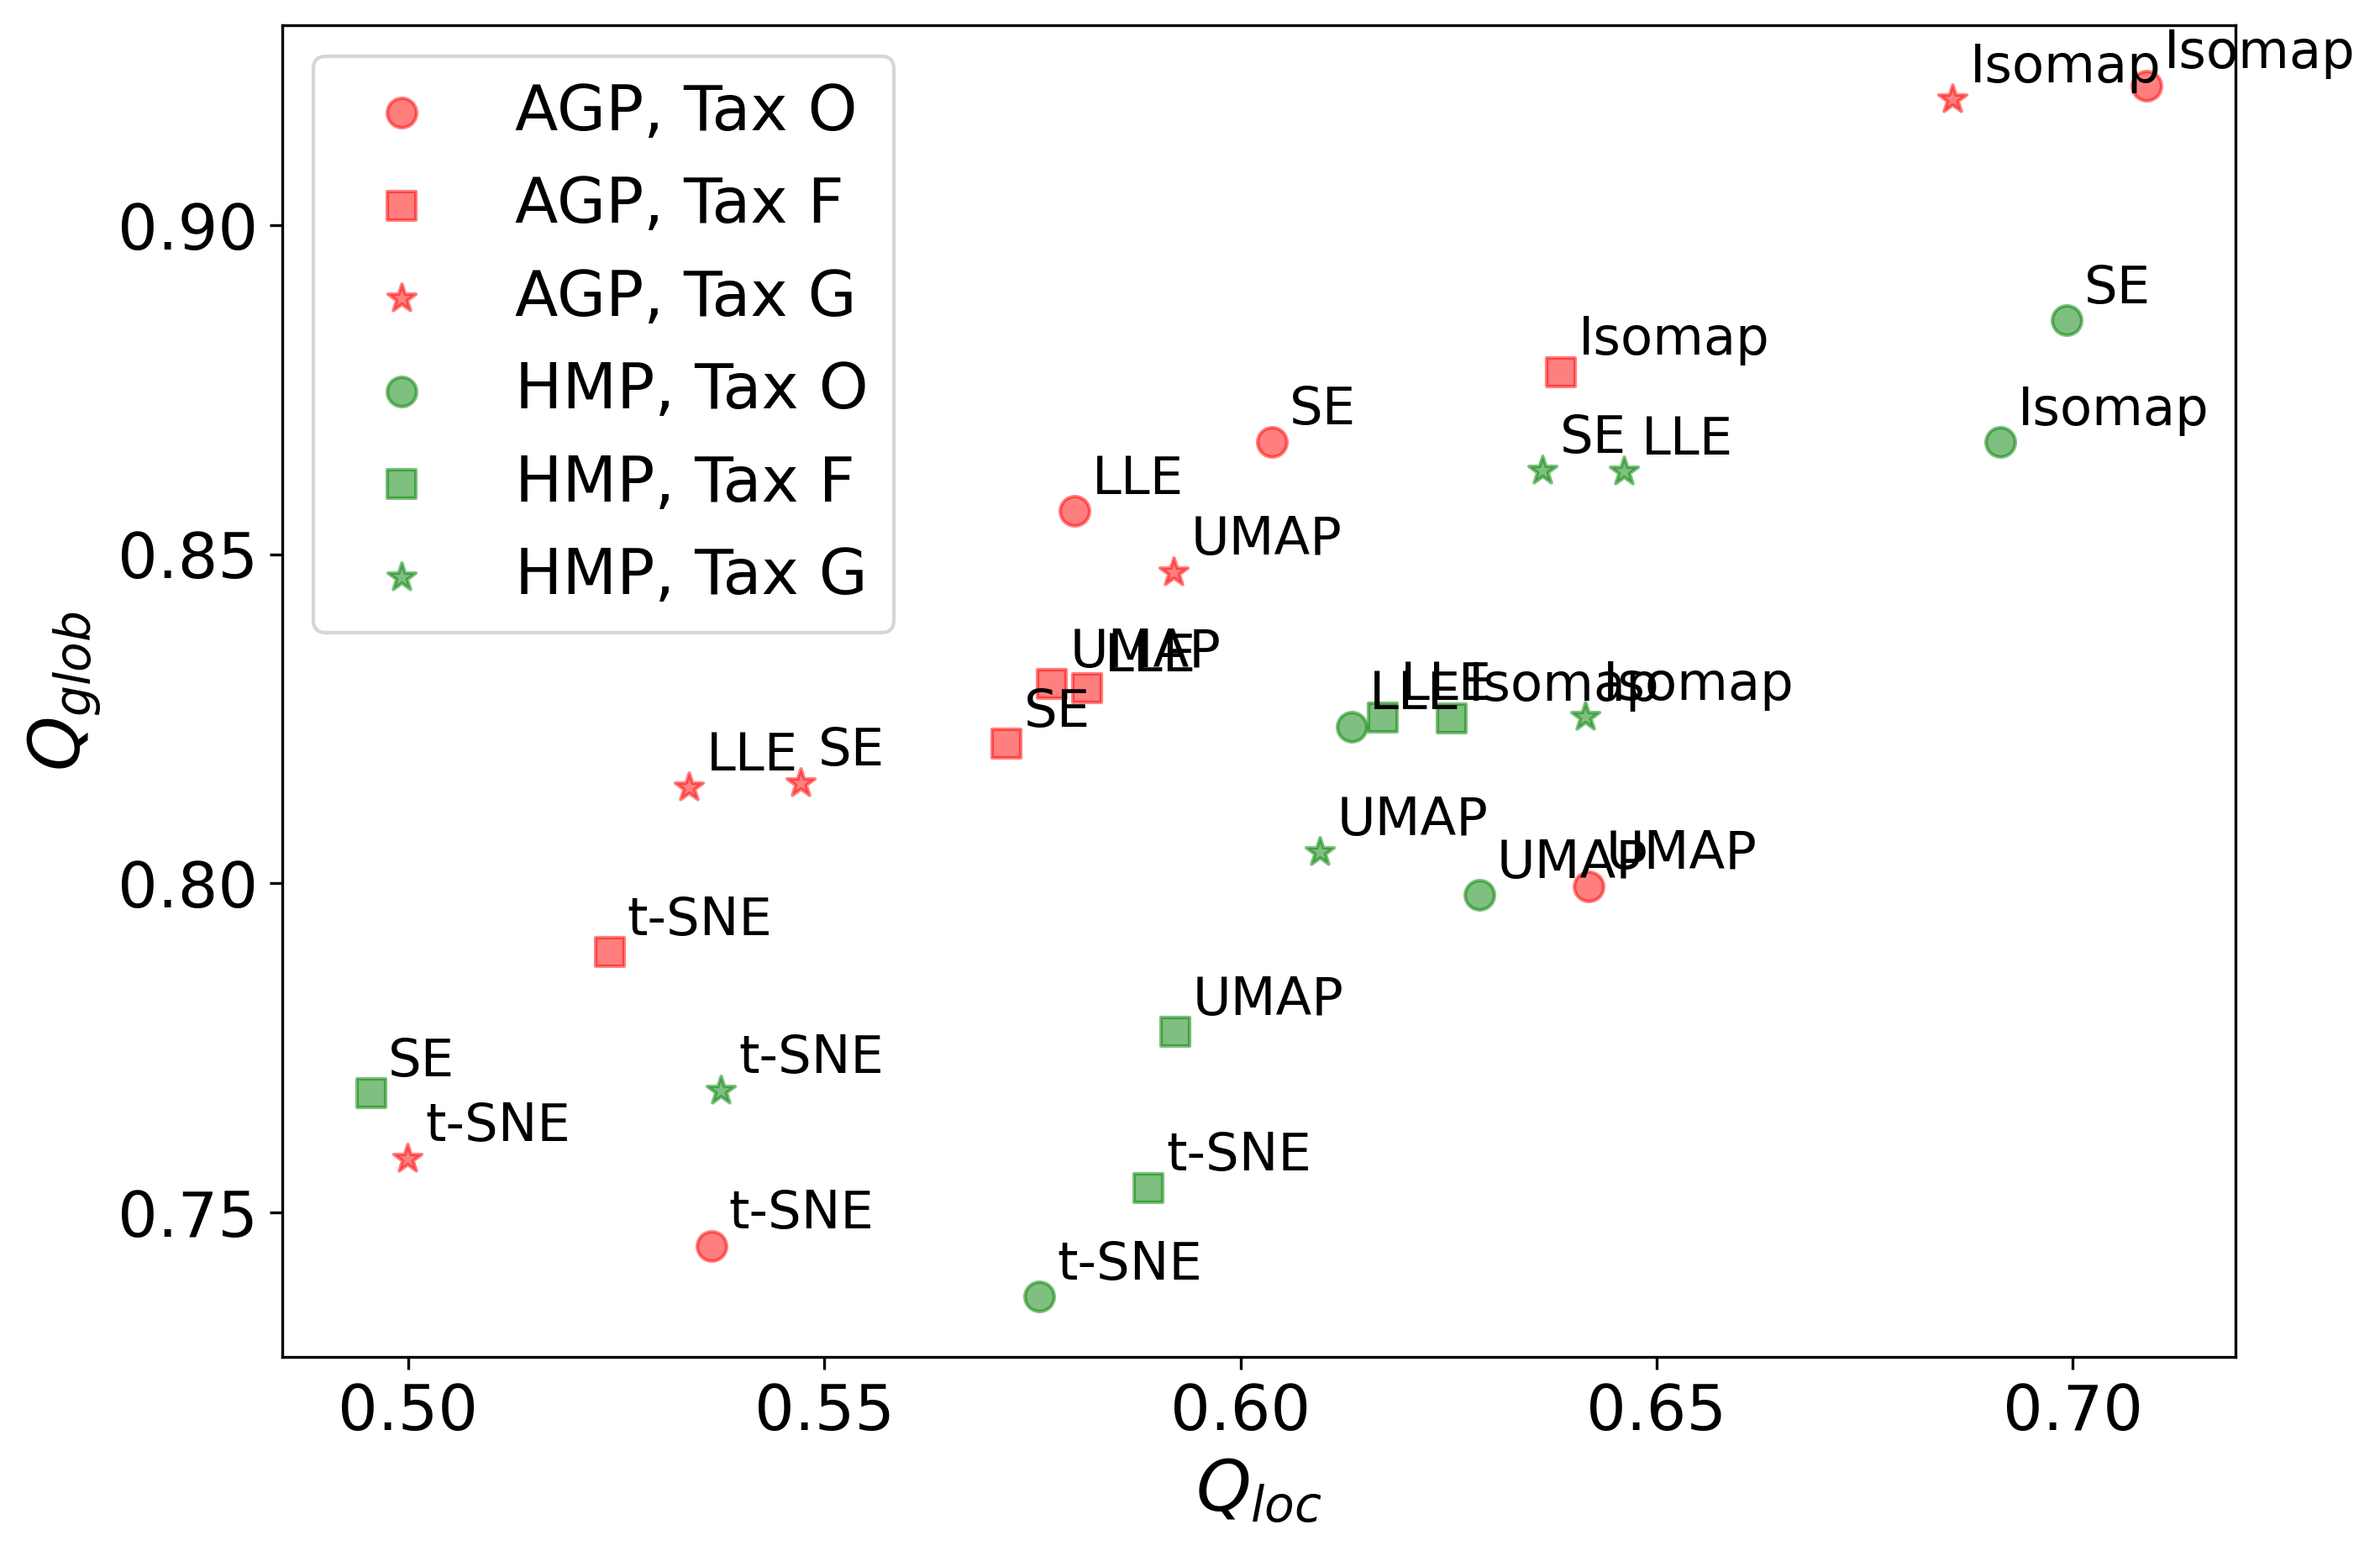

In [24]:
MSIZE=70
fig=plt.figure(figsize=(10,7),dpi=300)
plt.xlabel(r"$Q_{loc}$", fontsize=20)
plt.ylabel(r"$Q_{glob}$", fontsize=20)


embeddingname_dict = {'spectral':'SE',
                       'ae':'AE',
                       'tsne':'t-SNE',
                       'umap':'UMAP',
                       'isomap':'Isomap',
                       'lle':'LLE',
                       'pca': 'PCA'}

markerdict = {
    'o':'o',
    'f':'s',
    'g':'*',
}

for dataset_name in ['AGP', 'HMP']:
    for tax_name in ['o', 'f', 'g']:
        label = dataset_name + '_' + tax_name
        
        data_embeddings_label = data_embeddings[label]
        
        for i, (embedding_name, metrics_dict) in enumerate(data_embeddings_label.items()):

            x = metrics_dict['Q_loc']
            y = metrics_dict['Q_glob']

            marker = markerdict[tax_name]
            color = 'red' if dataset_name == 'AGP' else 'green'

            legend_label = f'{dataset_name}, Tax {tax_name.capitalize()}' if i == 0 else None
            
            mp = plt.scatter(x, 
                             y, 
                             c=color, 
                             s=MSIZE, 
                             marker=marker, 
                             alpha=0.5,
                             label=legend_label)
    
            txt = embeddingname_dict[embedding_name]
            
            try:
                raise KeyError
#                 xytext = {'AGP_o_tsne':(-22, 10),
#                           'AGP_o_isomap':(-40, -25),
#                           'AGP_o_spectral':(-20, 10),
#                           'AGP_o_ae':(-20, 10),
#                           'AGP_o_lle':(0, -20),#
#                           'AGP_f_umap':(-10, 10),
#                           'AGP_f_lle':(-15,-20),
#                           'AGP_f_ae':(5,-15),
#                           'AGP_f_spectral':(-25, 0),
#                           'AGP_f_isomap':(-15, -25),#
#                           'AGP_g_lle':(-30,0),#
#                           'AGP_g_ae':(-25,0),
#                           'AGP_g_umap':(-20,5), # 
#                           'AGP_g_tsne':(0,-20),
#                           'AGP_g_isomap':(-60, 0),
#                           'AGP_g_spectral':(-20, 10),#
#                           'HMP_o_spectral': (10,-20),
#                           'HMP_o_ae': (-10,15),
#                           'HMP_o_lle': (10,-10), #
#                           'HMP_o_umap': (10,-20),
#                           'HMP_o_isomap': (-30, -20),
#                           'HMP_f_lle': (-15, -20), 
#                           'HMP_f_isomap': (-15, 10), #
#                           'HMP_f_umap': (5, 5), #
#                           'HMP_f_spectral': (0, -20), #
#                           'HMP_f_ae': (10, 0),
#                           'HMP_g_spectral': (-5, -15), 
#                           'HMP_g_lle': (5, -10), #
#                           'HMP_g_tsne': (-48, -5), 
#                           'HMP_g_ae': (-25, 5),
#                           'HMP_g_umap': (5, -5),
#                           'HMP_g_isomap': (5, -3) #
                          
#                          }[label + '_' + embedding_name]
            except KeyError:
                xytext = (5,5)

            plt.annotate(txt, 
                         (x, y), 
                         annotation_clip=True, 
                         fontsize=15, 
                         xytext=xytext, 
                         textcoords="offset points")
    
plt.legend(fontsize=18)
plt.locator_params(nbins=5)
plt.tick_params(axis='both', labelsize=18)
plt.show()